Data processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam




Uplod Data

In [ ]:
data = pd.read_csv('/content/MarketPricePrediction.csv')


Data processing

In [ ]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
data.drop_duplicates(inplace=True)
data = pd.get_dummies(data, columns=['market', 'state', 'city'], drop_first=True)

<ipython-input-15-610b7ece7412>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


EDA

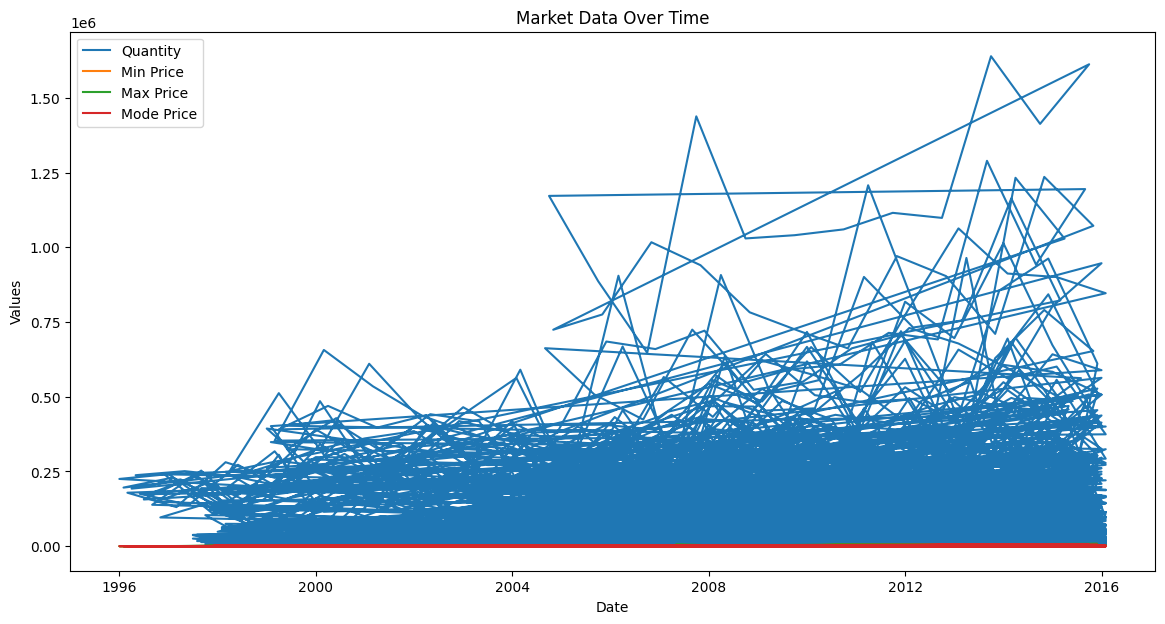

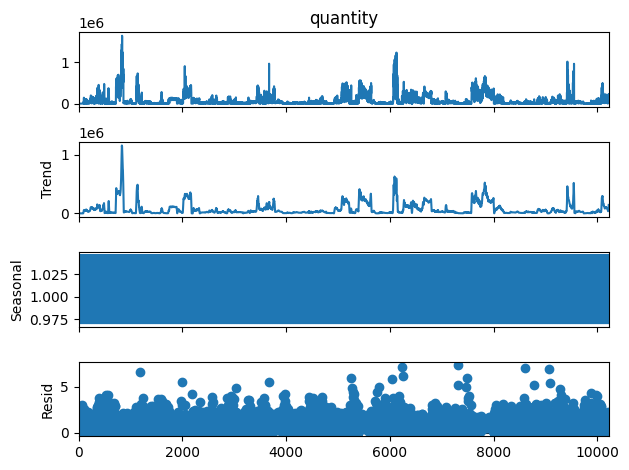

In [ ]:
# رسم السلاسل الزمنية للكمية والأسعار
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['quantity'], label='Quantity')
plt.plot(data['date'], data['priceMin'], label='Min Price')
plt.plot(data['date'], data['priceMax'], label='Max Price')
plt.plot(data['date'], data['priceMod'], label='Mode Price')
plt.legend()
plt.title('Market Data Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.show()

# تفكيك السلاسل الزمنية
result = seasonal_decompose(data['quantity'], model='multiplicative', period=12)
result.plot()
plt.show()


Feature engineering

In [ ]:
data['quantity_lag1'] = data['quantity'].shift(1)
data['priceMin_lag1'] = data['priceMin'].shift(1)
data['priceMax_lag1'] = data['priceMax'].shift(1)
data['priceMod_lag1'] = data['priceMod'].shift(1)

data['quantity_roll_mean'] = data['quantity'].rolling(window=3).mean()
data['quantity_roll_std'] = data['quantity'].rolling(window=3).std()

data.dropna(inplace=True)


Spliting Data

In [ ]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)


Training different models

ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

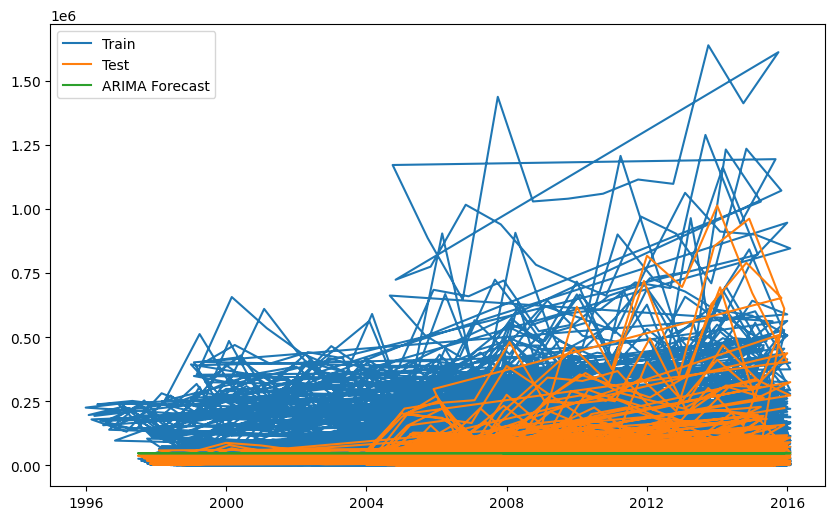

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# إعداد البيانات لنموذج ARIMA
arima_train = train.set_index('date')['quantity']

# تدريب النموذج
model_arima = ARIMA(arima_train, order=(1, 1, 1))
arima_result = model_arima.fit()

# التنبؤ بالقيم المستقبلية
arima_forecast = arima_result.forecast(steps=len(test))
arima_pred = arima_forecast

# عرض التنبؤات
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['quantity'], label='Train')
plt.plot(test['date'], test['quantity'], label='Test')
plt.plot(test['date'], arima_pred, label='ARIMA Forecast')
plt.legend()
plt.show()


SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

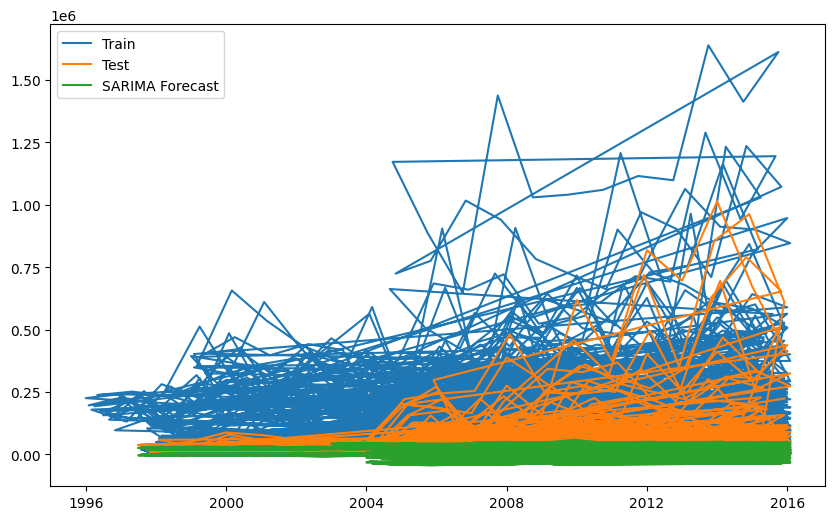

In [ ]:
# إعداد البيانات لنموذج SARIMA
sarima_train = train.set_index('date')['quantity']

# تدريب النموذج
model_sarima = SARIMAX(sarima_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = model_sarima.fit()

# التنبؤ بالقيم المستقبلية
sarima_forecast = sarima_result.get_forecast(steps=len(test))
sarima_pred = sarima_forecast.predicted_mean

# عرض التنبؤات
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['quantity'], label='Train')
plt.plot(test['date'], test['quantity'], label='Test')
plt.plot(test['date'], sarima_pred, label='SARIMA Forecast')
plt.legend()
plt.show()


Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc0hcmij2/3__0hb9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc0hcmij2/1_wrdqdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93013', 'data', 'file=/tmp/tmpc0hcmij2/3__0hb9u.json', 'init=/tmp/tmpc0hcmij2/1_wrdqdi.json', 'output', 'file=/tmp/tmpc0hcmij2/prophet_modelw_k5an1_/prophet_model-20240526091145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:11:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


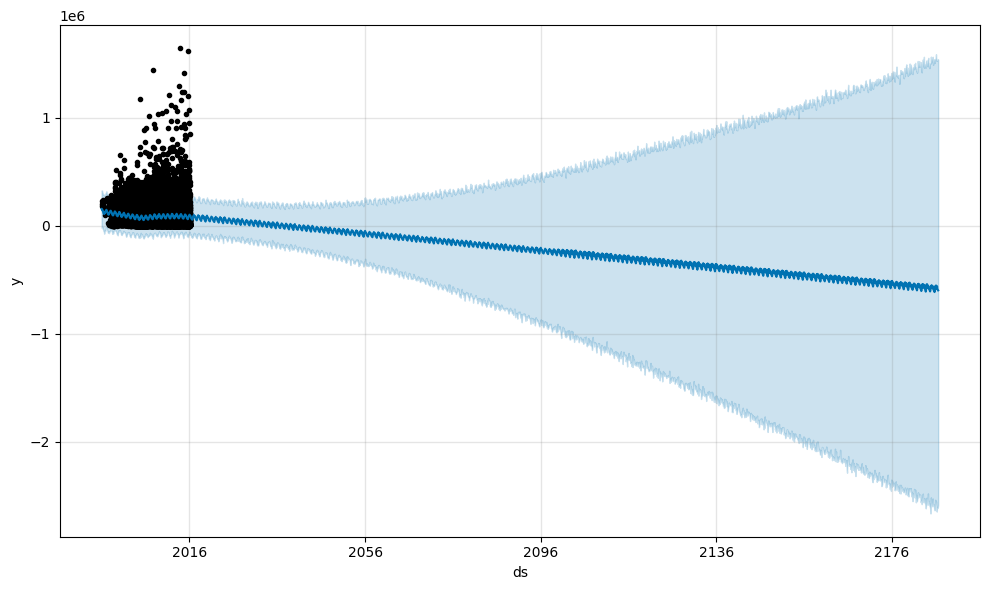

In [ ]:
# إعداد البيانات لنموذج Prophet
prophet_data = train[['date', 'quantity']].rename(columns={'date': 'ds', 'quantity': 'y'})

# تدريب النموذج
model_prophet = Prophet()
model_prophet.fit(prophet_data)

# إعداد البيانات المستقبلية
future = model_prophet.make_future_dataframe(periods=len(test), freq='M')
forecast = model_prophet.predict(future)

# عرض التنبؤات
model_prophet.plot(forecast)
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler


LSTM

64/64 [==============================] - 0s 2ms/step


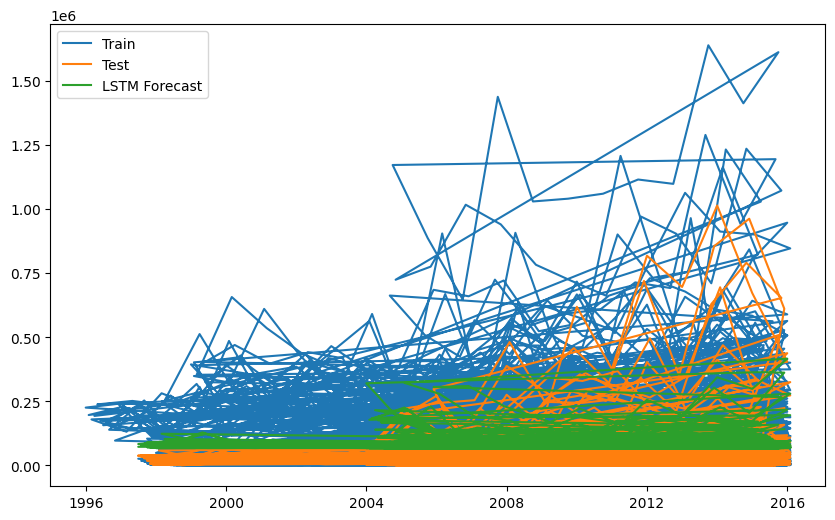

In [ ]:
# إعداد البيانات لنموذج LSTM
def create_lstm_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# تحضير البيانات
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['quantity'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['quantity'].values.reshape(-1, 1))

time_step = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_step)
X_test, y_test = create_lstm_dataset(test_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# بناء نموذج LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# تدريب النموذج
model_lstm.fit(X_train, y_train, batch_size=1, epochs=1)

# التنبؤ بالقيم المستقبلية
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# عرض التنبؤات
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['quantity'], label='Train')
plt.plot(test['date'], test['quantity'], label='Test')
plt.plot(test['date'][time_step + 1:], test_predict, label='LSTM Forecast')
plt.legend()
plt.show()


Model evaluation

In [ ]:
# حساب MAE وMSE وRMSE لنموذج ARIMA
mae_arima = mean_absolute_error(test['quantity'], arima_pred)
mse_arima = mean_squared_error(test['quantity'], arima_pred)
rmse_arima = np.sqrt(mse_arima)

# حساب MAE وMSE وRMSE لنموذج SARIMA
mae_sarima = mean_absolute_error(test['quantity'], sarima_pred)
mse_sarima = mean_squared_error(test['quantity'], sarima_pred)
rmse_sarima = np.sqrt(mse_sarima)

# حساب MAE وMSE وRMSE لنموذج Prophet
y_true = test['quantity'].values
y_pred_prophet = forecast.set_index('ds').loc[test['date'], 'yhat'].values
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
mse_prophet = mean_squared_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mse_prophet)

# حساب MAE وMSE وRMSE لنموذج LSTM
mae_lstm = mean_absolute_error(test['quantity'][time_step + 1:], test_predict)
mse_lstm = mean_squared_error(test['quantity'][time_step + 1:], test_predict)
rmse_lstm = np.sqrt(mse_lstm)

# طباعة النتائج
print(f'ARIMA - MAE: {mae_arima}, MSE: {mse_arima}, RMSE: {rmse_arima}')
print(f'SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}, RMSE: {rmse_sarima}')
print(f'Prophet - MAE: {mae_prophet}, MSE: {mse_prophet}, RMSE: {rmse_prophet}')
print(f'LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}')


ARIMA - MAE: 45969.03353595132, MSE: 7251618984.018829, RMSE: 85156.43830045282
SARIMA - MAE: 55908.64657722915, MSE: 10762350304.686823, RMSE: 103741.74812816113
Prophet - MAE: 69378.1304386932, MSE: 8566914869.077621, RMSE: 92557.62998844353
LSTM - MAE: 59364.900856657274, MSE: 5958580014.103945, RMSE: 77191.83903822959
